# Multi-class Image Classification
> We've just been through a bunch of the following steps with a binary classification problem (pizza vs. steak), now we're going to step things up a notch with 10 classes of food.

1. Become one with the data
2. Preprocess the data (get it ready for a model)
3. Create a model (start with a baseline)
4. Fit the model (overfit it to make sure it works)
5. Evaluate the model
6. Adjust the different hyperparameters and improve the model (try to beat baseline/reduce overfitting)
7. Repeat it until satisfied.


## Import and become the data

In [1]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# Unzip our data
zip_ref  = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-12-26 18:08:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf, 2607:f8b0:4023:c06::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   181MB/s    in 2.7s    

2023-12-26 18:09:02 (181 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [2]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_all_data
There are 10 directories and 0 images in 10_food_classes_all_data/train
There are 0 directories and 750 images in 10_food_classes_all_data/train/chicken_wings
There are 0 directories and 750 images in 10_food_classes_all_data/train/sushi
There are 0 directories and 750 images in 10_food_classes_all_data/train/grilled_salmon
There are 0 directories and 750 images in 10_food_classes_all_data/train/chicken_curry
There are 0 directories and 750 images in 10_food_classes_all_data/train/hamburger
There are 0 directories and 750 images in 10_food_classes_all_data/train/fried_rice
There are 0 directories and 750 images in 10_food_classes_all_data/train/ice_cream
There are 0 directories and 750 images in 10_food_classes_all_data/train/ramen
There are 0 directories and 750 images in 10_food_classes_all_data/train/steak
There are 0 directories and 750 images in 10_food_classes_all_data/train/pizza
There are 10 directories and 0 imag

In [3]:
# Setup the train and test directories

train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

# Let's get the subdirectories (these are our class names)
import pathlib
import numpy as np

data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

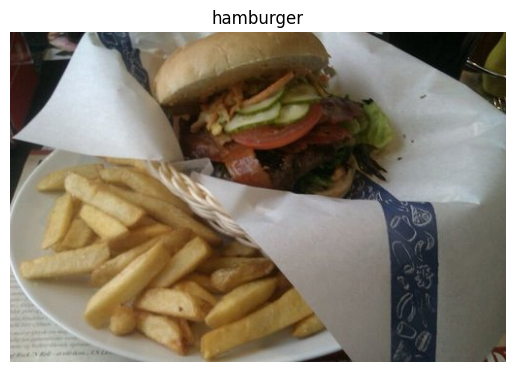

Img shape: (341, 512, 3)


In [4]:
# Visualize!
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import random

def view_random_img(target_dir, target_class):
  target_folder = target_dir  + target_class

  random_img = random.sample(os.listdir(target_folder), 1)

  img = mpimg.imread(target_folder + "/" + random_img[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")
  plt.show()

  print("Img shape:", img.shape)
  return tf.constant(img)

img = view_random_img(target_dir=train_dir,
                      target_class=random.choice(class_names))

## 2. Preprocess the data
1. Turn all data into numbers (Neural networks cannot handle with images)
2. Make sure all of your tensors are the right shape.
3. Scale features (normalize or standardize, neural networks tend to prefer normalization)

In [5]:
print(train_dir)
print(test_dir)

10_food_classes_all_data/train/
10_food_classes_all_data/test/


> Turn all data into batches!
*** A batch is small subset of data. Rather than look at tones of images at one time, a model might look 32 at a one time.***

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale
train_datagen = ImageDataGenerator(rescale=1/255.) # Get the all pixel values between 0 & 1
test_datagen = ImageDataGenerator(rescale=1/255.) # Get the all pixel values between 0 & 1

train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224, 224),
                                             class_mode="categorical",
                                             batch_size=32)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## 3. Create a CNN model (start with a baseline)

In [7]:
import tensorflow as tf
# 1.Create the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=10, # Decide how many filters should pass over an input tensor (e.g. sliding windows over an image)
                           kernel_size=3, # (3,3) -> Determines the shape of the filters (sliding windows) over the output.
                           strides=1, # The number of steps a filter take across an image at a time.
                           padding="valid",

                           #pads the target tensor with zeros (if "same") to preserve input shape.Or leaves in target.
                           #Shortly, if you want to hold more information in your input tensor, you'd leave it as same.
                           #if "same" output shape is same as input shape. if "valid" output shape gets compressed.

                           activation="relu",
                           input_shape=(224,224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax")
])

# 2. Compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# 3. Fit the model
history = model.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 38s 139ms/step - loss: 2.1363 - accuracy: 0.2165 - val_loss: 1.9708 - val_accuracy: 0.2776
Epoch 2/5
235/235 [==============================] - 29s 124ms/step - loss: 1.9004 - accuracy: 0.3455 - val_loss: 1.9305 - val_accuracy: 0.3212
Epoch 3/5
235/235 [==============================] - 32s 135ms/step - loss: 1.6481 - accuracy: 0.4411 - val_loss: 1.9845 - val_accuracy: 0.3300
Epoch 4/5
235/235 [==============================] - 29s 124ms/step - loss: 1.1826 - accuracy: 0.6084 - val_loss: 2.1424 - val_accuracy: 0.3144
Epoch 5/5
235/235 [==============================] - 30s 129ms/step - loss: 0.6263 - accuracy: 0.7967 - val_loss: 3.0868 - val_accuracy: 0.2628


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

## 5. Evaluate the model

In [9]:
model.evaluate(test_data)

79/79 [==============================] - 8s 96ms/step - loss: 3.0868 - accuracy: 0.2628


[3.0867812633514404, 0.262800008058548]

In [10]:
history.history

{'loss': [2.1362850666046143,
  1.9004358053207397,
  1.6481157541275024,
  1.1825823783874512,
  0.6263468861579895],
 'accuracy': [0.2165333330631256,
  0.345466673374176,
  0.4410666525363922,
  0.6083999872207642,
  0.79666668176651],
 'val_loss': [1.9707763195037842,
  1.9305033683776855,
  1.9844961166381836,
  2.1423792839050293,
  3.086780548095703],
 'val_accuracy': [0.2775999903678894,
  0.32120001316070557,
  0.33000001311302185,
  0.31439998745918274,
  0.262800008058548]}

In [11]:
import pandas as pd

def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.plot(epochs, loss, label="training loss")
  plt.plot(epochs, val_loss, label="validation loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, acc, label="accuracy")
  plt.plot(epochs, val_acc, label="validation accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()
  plt.show()

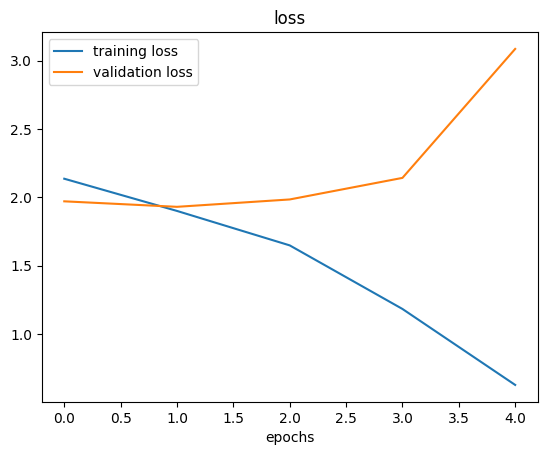

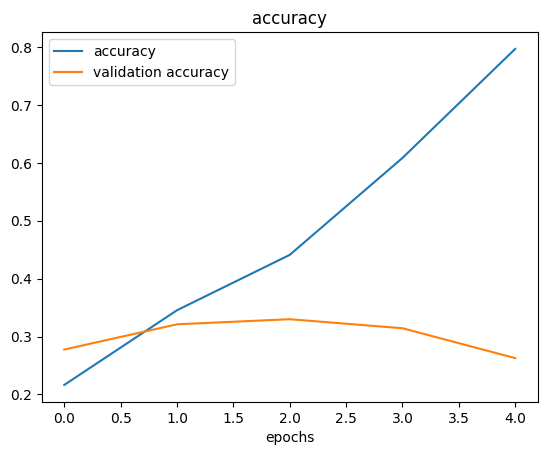

In [12]:
plot_loss_curves(history)

> what do these loss curves tell us ?

Well.. it seems our model is **overfitting** the training set quite badly...

## Adjust the model hyperparameters (to beat the baseline/reduce overfitting)

Due to its performance on the training data, it's clear our models is learning something...
However, it's not generalizing well to unseen data.

So let's try and fix overfitting by...

* **GET MORE DATA** - having more data gives a model more oppurtunity to learn diverse patterns...

* **SIMPLY THE MODEL** - if our current model is overfitting the data, it may be too complicated of a model. One way to simplify a model is to: reduce **of layers or reduce** **number of hidden units in layers**

* **USE DATA AUGMENTATION** - data augmentation manipulates the training data in such a way to add more diversity to it (without altering the original data)

* **USE TRANSFER LEARNING** - transfer learning leverages the patterns another model has learned on similar data to your own and allows you to use those patterns on your own data

### Simplify the model by removing 2 convolutional layers..


In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
model_2 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation="softmax")
])

model_2.compile(
    loss="categorical_crossentropy",
    optimizer = Adam(),
    metrics=["accuracy"]
)

history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 30s 121ms/step - loss: 2.1435 - accuracy: 0.2275 - val_loss: 1.9941 - val_accuracy: 0.2812
Epoch 2/5
235/235 [==============================] - 28s 118ms/step - loss: 1.7965 - accuracy: 0.3913 - val_loss: 1.8760 - val_accuracy: 0.3576
Epoch 3/5
235/235 [==============================] - 33s 139ms/step - loss: 1.3683 - accuracy: 0.5552 - val_loss: 2.0841 - val_accuracy: 0.3236
Epoch 4/5
235/235 [==============================] - 28s 120ms/step - loss: 0.8718 - accuracy: 0.7333 - val_loss: 2.1584 - val_accuracy: 0.3396
Epoch 5/5
235/235 [==============================] - 28s 121ms/step - loss: 0.4628 - accuracy: 0.8701 - val_loss: 2.7007 - val_accuracy: 0.3160


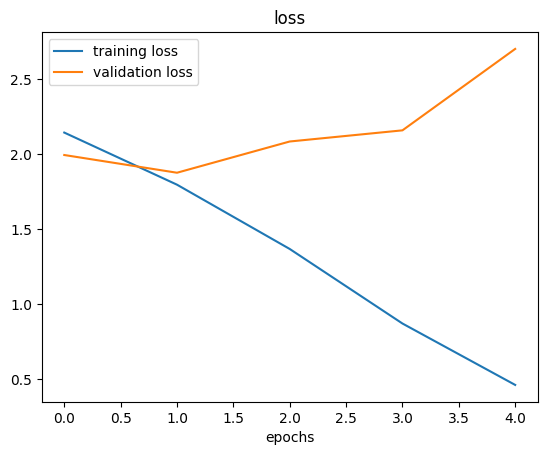

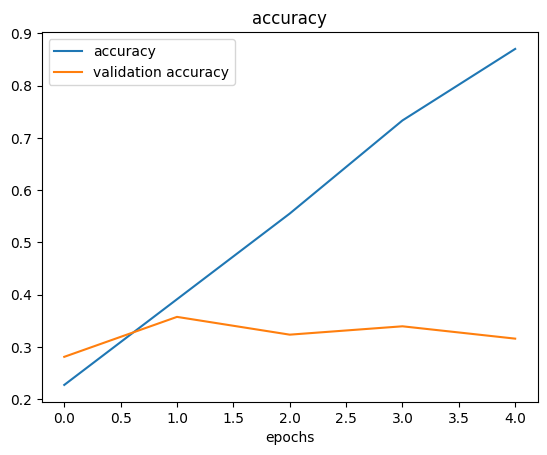

In [14]:
plot_loss_curves(history_2)

> It didn't work. lollllllllll.

we need to try other ways

### Trying to reduce overfitting with data augmentation ?

> Let's try and improve our model's results by using augmented training data.

Ideally we want to:

* Reduce overfitting (get the train and validation loss curves closer)
* Improve validation accuracy


In [15]:

train_datagen_augmented = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_data_augmented = train_datagen_augmented.flow_from_directory(
    directory = train_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = True
)

test_data = test_datagen.flow_from_directory(
    directory = test_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = "categorical",
)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [16]:
model_3 = tf.keras.models.clone_model(model)

model_3.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(),
    metrics=["accuracy"]
)

history_3 = model_3.fit(train_data_augmented,
            epochs=5,
            steps_per_epoch = len(train_data_augmented),
            validation_data = test_data,
            validation_steps = len(test_data))

Epoch 1/5
235/235 [==============================] - 113s 476ms/step - loss: 2.2077 - accuracy: 0.1705 - val_loss: 2.0472 - val_accuracy: 0.2568
Epoch 2/5
235/235 [==============================] - 109s 466ms/step - loss: 2.0889 - accuracy: 0.2549 - val_loss: 1.8924 - val_accuracy: 0.3388
Epoch 3/5
235/235 [==============================] - 111s 473ms/step - loss: 2.0118 - accuracy: 0.2984 - val_loss: 1.8991 - val_accuracy: 0.3276
Epoch 4/5
235/235 [==============================] - 118s 500ms/step - loss: 1.9684 - accuracy: 0.3173 - val_loss: 1.7551 - val_accuracy: 0.3940
Epoch 5/5
235/235 [==============================] - 113s 483ms/step - loss: 1.9118 - accuracy: 0.3372 - val_loss: 1.7407 - val_accuracy: 0.4120


In [18]:
model_2.evaluate(test_data)

79/79 [==============================] - 10s 132ms/step - loss: 2.7007 - accuracy: 0.3160


[2.700697422027588, 0.3160000145435333]

In [19]:
model_3.evaluate(test_data)

79/79 [==============================] - 7s 94ms/step - loss: 1.7407 - accuracy: 0.4120


[1.740700364112854, 0.41200000047683716]

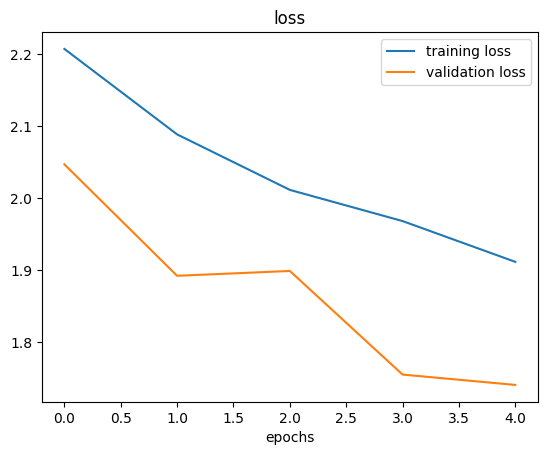

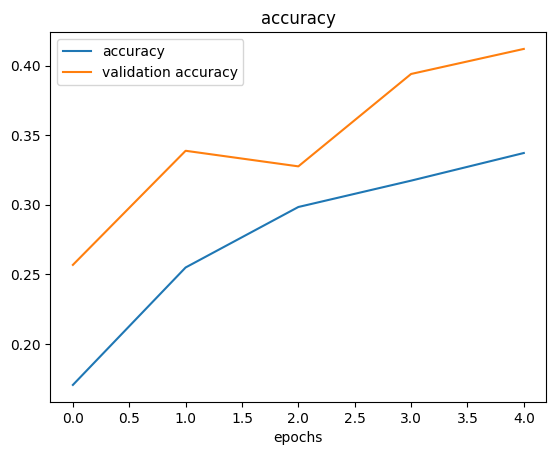

In [17]:
plot_loss_curves(history_3)

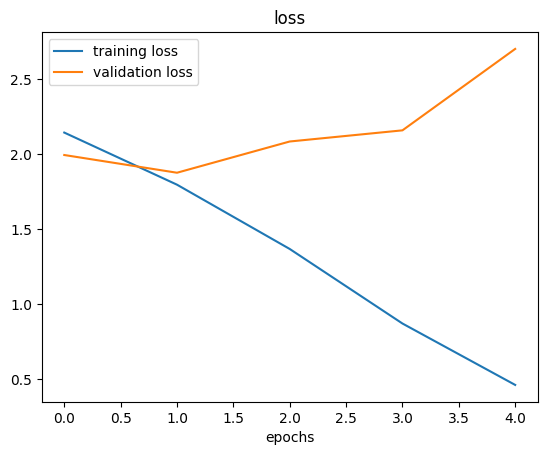

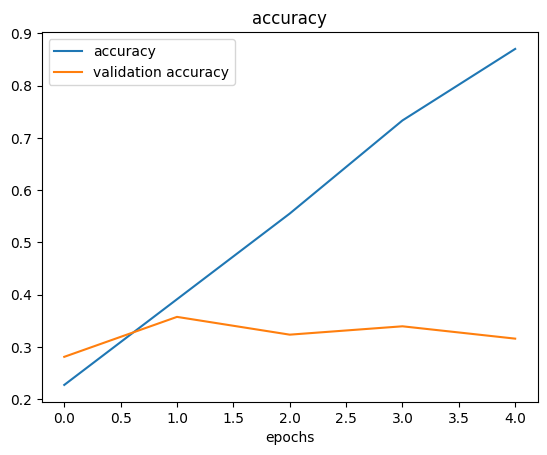

In [21]:
plot_loss_curves(history_2)

> Woah! That looks much better, the loss curves are much closer to each other than the baseline model and they look like they're heading in the right direction (certainly not the wrong direction) so if we were to train for longer, we might see further improvements.

## Repat until satisfied

We could keep going here... Continally trying to bring our loss curves closer together and trying to improve the validation/test accuracy.

how?

By running lots of experiments,namely:

  * restructuring our model's architechture (increasing layers/hidden units)
  * adjust the learning rate
  * try different methods of data augmentation (adjust the hyperparameters in our ImageDataGenerator instance)
  * training for longer (e.g. 10 epochs instead of 5 epochs)
  * try **transfer learning**

In [24]:
model_4 = Sequential([
    Conv2D(10, 3, strides=1, padding="valid", activation="relu", input_shape=(224, 224, 3), ),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation="softmax")
])

model_4.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(),
    metrics=["accuracy"]
)

history_4 = model_4.fit(train_data_augmented,
                        epochs=10,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/10
235/235 [==============================] - 113s 467ms/step - loss: 2.2155 - accuracy: 0.1776 - val_loss: 2.1146 - val_accuracy: 0.2508
Epoch 2/10
235/235 [==============================] - 112s 478ms/step - loss: 2.1057 - accuracy: 0.2379 - val_loss: 1.9789 - val_accuracy: 0.3000
Epoch 3/10
235/235 [==============================] - 109s 462ms/step - loss: 2.0577 - accuracy: 0.2707 - val_loss: 1.9264 - val_accuracy: 0.3248
Epoch 4/10
235/235 [==============================] - 108s 460ms/step - loss: 2.0098 - accuracy: 0.2925 - val_loss: 1.8613 - val_accuracy: 0.3300
Epoch 5/10
235/235 [==============================] - 109s 461ms/step - loss: 1.9653 - accuracy: 0.3172 - val_loss: 1.7894 - val_accuracy: 0.3800
Epoch 6/10
235/235 [==============================] - 108s 460ms/step - loss: 1.9440 - accuracy: 0.3227 - val_loss: 1.7868 - val_accuracy: 0.3728
Epoch 7/10
235/235 [==============================] - 109s 463ms/step - loss: 1.8971 - accuracy: 0.3431 - val_loss: 1.8790 -

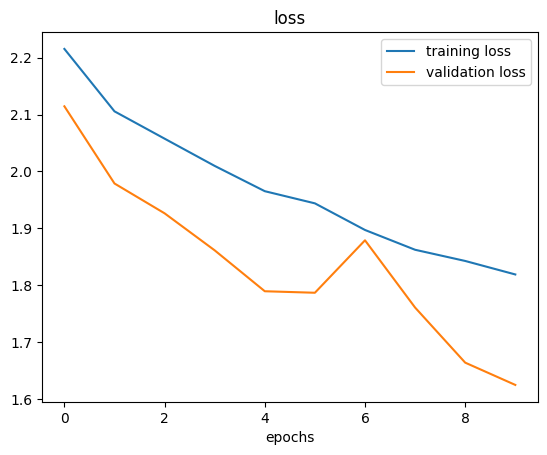

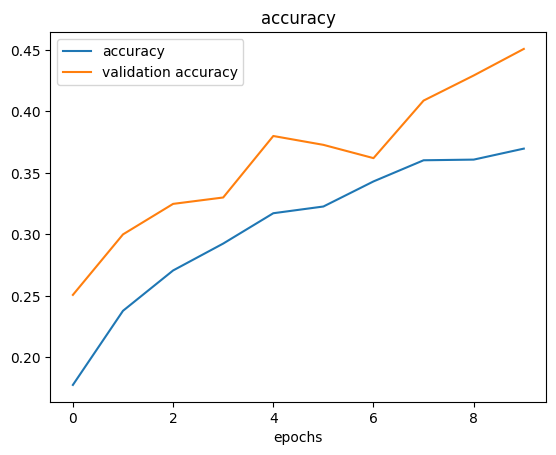

In [25]:
plot_loss_curves(history_4)

In [26]:
model_4.evaluate(test_data)

79/79 [==============================] - 10s 131ms/step - loss: 1.6247 - accuracy: 0.4508


[1.6247212886810303, 0.45080000162124634]

In [27]:
model_3.evaluate(test_data)

79/79 [==============================] - 7s 83ms/step - loss: 1.7407 - accuracy: 0.4120


[1.7407000064849854, 0.41200000047683716]

## Making a prediction with our trained model

> Let's use our trained model to make some predictions on oyr own custom images!

In [28]:
print("class names: ", class_names)

class names:  ['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [66]:
# Download some custom images
!wget https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/images/03-pizza-dad.jpeg?raw=true
!wget https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/images/03-sushi.jpeg?raw=true
!wget https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/images/03-hamburger.jpeg?raw=true
!wget https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/images/03-steak.jpeg?raw=true

--2023-12-26 20:08:52--  https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/images/03-pizza-dad.jpeg?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/images/03-pizza-dad.jpeg [following]
--2023-12-26 20:08:52--  https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/images/03-pizza-dad.jpeg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg [following]
--2023-12-26 20:08:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.gi

In [76]:
def load_and_prep_img(filename, img_shape=224):
  """
    reads and image from filename, turns it into a tensor and reshapes it to
    (img_shape, img_shape, color_channels)
  """
  # Read the img
  img = tf.io.read_file(filename)

  # Decode and  read the file into a tensor
  img = tf.image.decode_image(img)

  # Resize the img
  img = tf.image.resize(img, size=[img_shape, img_shape])

  # Rescale the img
  img = img/255.

  return img


In [77]:

def pred_and_plot(model, filename, class_names=class_names):
  """
  imports the image located at filename, makes a prediction with model and plots
  the image with predicted class as title
  """

  img = load_and_prep_img(filename)
  pred = model.predict(tf.expand_dims(img, axis=0))


  if len(pred[0]) > 1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[int(tf.round(pred))]

  print(pred_class)
  plt.imshow(img)
  plt.axis("off")
  plt.title(pred_class)
  plt.show()

1/1 [==============================] - 0s 108ms/step
hamburger


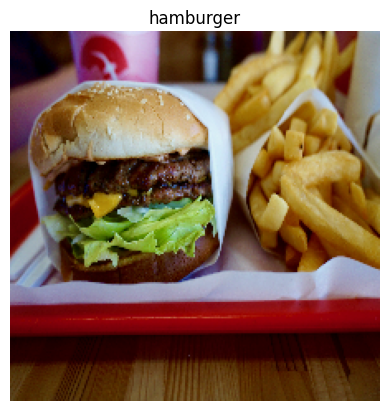

In [78]:
pred_and_plot(model_4, "/content/03-hamburger.jpeg?raw=true")

1/1 [==============================] - 0s 18ms/step
pizza


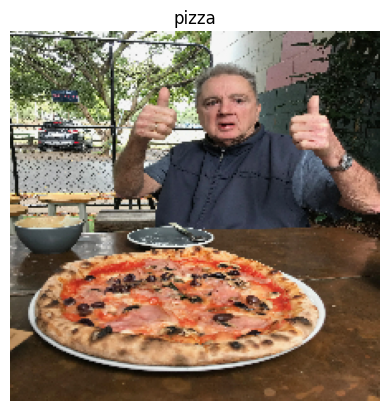

In [79]:
pred_and_plot(model_4,"/content/03-pizza-dad.jpeg?raw=true" )

1/1 [==============================] - 0s 18ms/step
steak


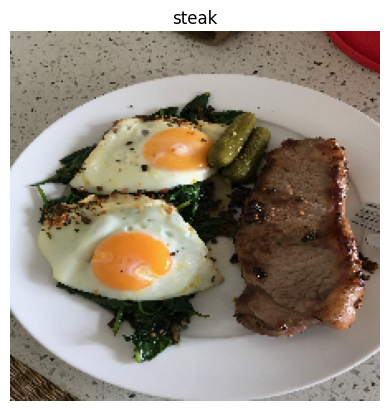

In [80]:
pred_and_plot(model_4,"/content/03-steak.jpeg?raw=true" )

1/1 [==============================] - 0s 29ms/step
chicken_wings


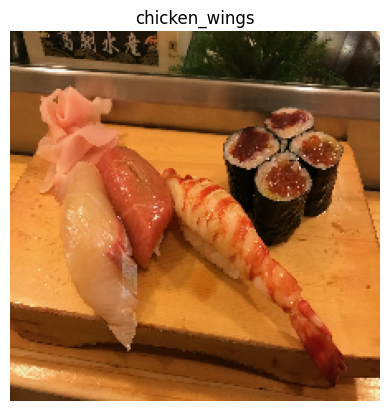

In [82]:
pred_and_plot(model_4,"/content/03-sushi.jpeg?raw=true" )

  ## Save the model

In [83]:
model_4.save("saved_trained_model_4")

In [84]:
loaded_model_4 = tf.keras.models.load_model("saved_trained_model_4")
loaded_model_4.evaluate(test_data)

79/79 [==============================] - 8s 98ms/step - loss: 1.6247 - accuracy: 0.4508


[1.6247210502624512, 0.45080000162124634]

In [85]:
model_4.evaluate(test_data)

79/79 [==============================] - 8s 106ms/step - loss: 1.6247 - accuracy: 0.4508


[1.6247210502624512, 0.45080000162124634]